In [1]:
require 'loadcaffe'
require 'inn'
require 'image'
require 'dcnn'

-- Loads the mapping from net outputs to human readable labels
function load_synset()
  local file = io.open 'synset_words.txt'
  local list = {}
  while true do
    local line = file:read()
    if not line then break end
    table.insert(list, string.sub(line,11))
  end
  return list
end

-- Converts an image from RGB to BGR format and subtracts mean
function preprocess(im, img_mean)
  -- rescale the image
  local im3 = image.scale(im,224,224,'bilinear')*255
  -- RGB2BGR
  local im4 = im3:clone()
  im4[{1,{},{}}] = im3[{3,{},{}}]
  im4[{3,{},{}}] = im3[{1,{},{}}]

  -- subtract imagenet mean
  return im4 - image.scale(img_mean, 224, 224, 'bilinear')
end

-- Setting up networks 
print '==> Loading network'

prototxt_name = '/usr/local/data/CaffeZoo/VGG_ILSVRC_16_layers/VGG_ILSVRC_16_layers_deploy.prototxt'
binary_name = '/usr/local/data/CaffeZoo/VGG_ILSVRC_16_layers/VGG_ILSVRC_16_layers.caffemodel'

net = loadcaffe.load(prototxt_name, binary_name, 'cudnn')

net:cuda()
-- as we want to classify, let's disable dropouts by enabling evaluation mode
net:evaluate()

print '==> Loading synsets'
synset_words = load_synset()

print '==> Loading image and imagenet mean'
image_name = 'Goldfish3.jpg'
--image_name = 'lena.jpg'
--image_name='people.jpg'
img_mean_name = 'ilsvrc_2012_mean.t7'

im = image.load(image_name)
img_mean = torch.load(img_mean_name).img_mean:transpose(3,1)

-- Have to resize and convert from RGB to BGR and subtract mean
print '==> Preprocessing'
I = preprocess(im, img_mean)


-- Replace pooling by dual pooling
unpooling_layers = dcnn:ReplaceDualPoolingModule(net)

_,classes = net:forward(I:cuda()):view(-1):float():sort(true)

for i=1,5 do
  print('predicted class '..tostring(i)..': ', synset_words[classes[i] ])
end

==> Loading network	


Successfully loaded /usr/local/data/CaffeZoo/VGG_ILSVRC_16_layers/VGG_ILSVRC_16_layers.caffemodel


conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3
conv2_2: 128 128 3 3
conv3_1: 256 128 3 3


conv3_2: 256 256 3 3


conv3_3: 256 256 3 3
conv4_1: 512 256 3 3


conv4_2: 512 512 3 3


conv4_3: 512 512 3 3


conv5_1: 512 512 3 3


conv5_2: 512 512 3 3


conv5_3: 512 512 3 3


fc6: 1 1 25088 4096


fc7: 1 1 4096 4096


fc8: 1 1 4096 1000


==> Loading synsets	
==> Loading image and imagenet mean	


==> Preprocessing	


predicted class 1: 	goldfish, Carassius auratus	
predicted class 2: 	tench, Tinca tinca	
predicted class 3: 	gar, garfish, garpike, billfish, Lepisosteus osseus	
predicted class 4: 	coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch	
predicted class 5: 	coral reef	


In [2]:
net

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> (13) -> (14) -> (15) -> (16) -> (17) -> (18) -> (19) -> (20) -> (21) -> (22) -> (23) -> (24) -> (25) -> (26) -> (27) -> (28) -> (29) -> (30) -> (31) -> (32) -> (33) -> (34) -> (35) -> (36) -> (37) -> (38) -> (39) -> (40) -> output]
  (1): cudnn.SpatialConvolution(3 -> 64, 3x3, 1,1, 1,1)
  (2): cudnn.ReLU
  (3): cudnn.SpatialConvolution(64 -> 64, 3x3, 1,1, 1,1)
  (4): cudnn.ReLU
  (5): dcnn.DualSpatialMaxPooling(2,2,2,2)
  (6): cudnn.SpatialConvolution(64 -> 128, 3x3, 1,1, 1,1)
  (7): cudnn.ReLU
  (8): cudnn.SpatialConvolution(128 -> 128, 3x3, 1,1, 1,1)
  (9): cudnn.ReLU
  (10): dcnn.DualSpatialMaxPooling(2,2,2,2)
  (11): cudnn.SpatialConvolution(128 -> 256, 3x3, 1,1, 1,1)
  (12): cudnn.ReLU
  (13): cudnn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1)
  (14): cudnn.ReLU
  (15): cudnn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1)
  (16): cudnn.ReLU
  (17): dcnn.DualSpatialMax

     1 : 
        cudnn.SpatialConvolution(3 -> 64, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 3
          output : CudaTensor - size: 64x224x224
          gradInput : CudaTensor - size: 3x224x224
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40b1aff8
          iSize : LongStorage - size: 4
          convDesc : cdata<struct cudnnConvolutionStruct *[1]>: 0x40b09668
          output_offset : 3211264
          gradBias : CudaTensor - size: 64
          algType : cdata<enum 852 [?]>: 0x40e8ab60
          extraBuffer : CudaTensor - empty
          extraBufferSizeInBytes : 0
          oDescForBias : cdata<struct cudnnTensorStruct *[1]>: 0x41102088
          oDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40e7f768
          groups : 1
          dH : 1
          dW : 1
          nOutputPlane : 64
          padH : 1
          kH : 3
          weight_offset : 1728
          finput : CudaTensor - empty
          biasDesc : cdata<struct cudnnTensorStruct *[1]>:

train : false
          gradWeight : CudaTensor - size: 64x3x3x3
          fgradInput : CudaTensor - empty
          kW : 3
          bias : CudaTensor - size: 64
          weightDesc : cdata<struct cudnnFilterStruct *[1]>: 0x41b600a8
        }
      2 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - size: 64x224x224
          gradInput : CudaTensor - empty
          nElem : 3211264
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40edd6a8
        }
      3 : 
        cudnn.SpatialConvolution(64 -> 64, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 64
          output : CudaTensor - size: 64x224x224
          gradInput : CudaTensor - size: 64x224x224
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x4072d158
          iSize : LongStorage - size: 4
          convDesc : cdata<struct cudnnConvolutionStruct *[1]>: 0x407351c0
          output_offset : 

          oDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40e52a40
          groups : 1
          dH : 1
          dW : 1
          nOutputPlane : 64
          padH : 1
          kH : 3
          weight_offset : 36864
          finput : CudaTensor - empty
          biasDesc : cdata<struct cudnnTensorStruct *[1]>: 0x41f35be8
          input_offset : 3211264
          weight : CudaTensor - size: 64x64x3x3
          train : false
          gradWeight : CudaTensor - size: 64x64x3x3
          fgradInput : CudaTensor - empty
          kW : 3
          bias : CudaTensor - size: 64
          weightDesc : cdata<struct cudnnFilterStruct *[1]>: 0x41e5dfc8
        }
      4 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - size: 64x224x224
          gradInput : CudaTensor - empty
          nElem : 3211264
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40e8fb10
        }
      5 : 
     

          gradInput : CudaTensor - empty
          indices : CudaTensor - size: 64x112x112
          dualModule : 
            dcnn.DualSpatialMaxUnpooling
            {
              gradInput : CudaTensor - empty
              dualModule : 
                dcnn.DualSpatialMaxPooling(2,2,2,2)
                {
                  dH : 2
                  dW : 2
                  padH : 0
                  gradInput : CudaTensor - empty
                  indices : CudaTensor - size: 64x112x112
                  dualModule : dcnn.DualSpatialMaxUnpooling
                  kH : 2
                  output : CudaTensor - size: 64x112x112
                  padW : 0
                  kW : 2
                }
              output : CudaTensor - size: 64x224x224
            }
          kH : 2
          output : CudaTensor - size: 64x112x112
          padW : 0
          kW : 2
        }
      6 : 


        cudnn.SpatialConvolution(64 -> 128, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 64
          output : CudaTensor - size: 128x112x112
          gradInput : CudaTensor - size: 64x112x112
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x41e626d8
          iSize : LongStorage - size: 4
          convDesc : cdata<struct cudnnConvolutionStruct *[1]>: 0x41fe37c0
          output_offset : 1605632
          gradBias : CudaTensor - size: 128
          algType : cdata<enum 852 [?]>: 0x41773730
          extraBuffer : CudaTensor - size: 576
          extraBufferSizeInBytes : 2304
          oDescForBias : cdata<struct cudnnTensorStruct *[1]>: 0x41f422d8
          oDesc : cdata<struct cudnnTensorStruct *[1]>: 0x41f39170
          groups : 1
          dH : 1
          dW : 1
          nOutputPlane : 128
          padH : 1
          kH : 3
          weight_offset : 73728
          finput : CudaTensor - empty
          biasDesc : cdata<struct cudnnTensorStruct 

}
      7 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - size: 128x112x112
          gradInput : CudaTensor - empty
          nElem : 1605632
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40e8fb50
        }
      8 : 
        cudnn.SpatialConvolution(128 -> 128, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 128
          output : CudaTensor - size: 128x112x112
          gradInput : CudaTensor - size: 128x112x112
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40be8ab8
          iSize : LongStorage - size: 4
          convDesc : cdata<struct cudnnConvolutionStruct *[1]>: 0x407ec8c8
          output_offset : 1605632
          gradBias : CudaTensor - size: 128
          algType : cdata<enum 852 [?]>: 0x4177ecb0
          extraBuffer : CudaTensor - size: 1152
          extraBufferSizeInBytes : 4608
          oDescForBias : cdata<struct cudnnTe


          input_offset : 1605632
          weight : CudaTensor - size: 128x128x3x3
          train : false
          gradWeight : CudaTensor - size: 128x128x3x3
          fgradInput : CudaTensor - empty
          kW : 3
          bias : CudaTensor - size: 128
          weightDesc : cdata<struct cudnnFilterStruct *[1]>: 0x407ecd00
        }
      9 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - size: 128x112x112
          gradInput : CudaTensor - empty
          nElem : 1605632
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x407e6c38
        }
      10 : 
        dcnn.DualSpatialMaxPooling(2,2,2,2)
        {
          dH : 2
          dW : 2
          padH : 0
          gradInput : CudaTensor - empty
          indices : CudaTensor - size: 128x56x56
          dualModule : 
            dcnn.DualSpatialMaxUnpooling
            {
              gradInput : CudaTensor - empty
  

     dH : 2
                  dW : 2
                  padH : 0
                  gradInput : CudaTensor - empty
                  indices : CudaTensor - size: 128x56x56
                  dualModule : dcnn.DualSpatialMaxUnpooling
                  kH : 2
                  output : CudaTensor - size: 128x56x56
                  padW : 0
                  kW : 2
                }
              output : CudaTensor - size: 128x112x112
            }
          kH : 2
          output : CudaTensor - size: 128x56x56
          padW : 0
          kW : 2
        }
      11 : 
        cudnn.SpatialConvolution(128 -> 256, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 128
          output : CudaTensor - size: 256x56x56
          gradInput : CudaTensor - size: 128x56x56
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x41f42cf8
          iSize : LongStorage - size: 4
          convDesc : cdata<struct cudnnConvolutionStruct *[1]>: 0x406d30a0
          output_offset : 8028

          algType : cdata<enum 852 [?]>: 0x41e6d370
          extraBuffer : CudaTensor - size: 1152
          extraBufferSizeInBytes : 4608
          oDescForBias : cdata<struct cudnnTensorStruct *[1]>: 0x40b172f8
          oDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40e6d948
          groups : 1
          dH : 1
          dW : 1
          nOutputPlane : 256
          padH : 1
          kH : 3
          weight_offset : 294912
          finput : CudaTensor - empty
          biasDesc : cdata<struct cudnnTensorStruct *[1]>: 0x41ac0878
          input_offset : 401408
          weight : CudaTensor - size: 256x128x3x3
          train : false
          gradWeight : CudaTensor - size: 256x128x3x3
          fgradInput : CudaTensor - empty
          kW : 3
          bias : CudaTensor - size: 256
          weightDesc : cdata<struct cudnnFilterStruct *[1]>: 0x40ed5e70
        }
      12 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          tr

       cudnn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 256
          output : CudaTensor - size: 256x56x56
          gradInput : CudaTensor - size: 256x56x56
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x41abd5a8
          iSize : LongStorage - size: 4
          convDesc : cdata<struct cudnnConvolutionStruct *[1]>: 0x407ee628
          output_offset : 802816
          gradBias : CudaTensor - size: 256
          algType : cdata<enum 852 [?]>: 0x4072d4e8
          extraBuffer : CudaTensor - size: 2304
          extraBufferSizeInBytes : 9216
          oDescForBias : cdata<struct cudnnTensorStruct *[1]>: 0x40ec1950
          oDesc : cdata<struct cudnnTensorStruct *[1]>: 0x407f1ba0
          groups : 1
          dH : 1
          dW : 1
          nOutputPlane : 256
          padH : 1
          kH : 3
          weight_offset : 589824
          finput : CudaTensor - empty
          biasDesc : cdata<struct cudnnTensorStruct *[

        train : false
          output : CudaTensor - size: 256x56x56
          gradInput : CudaTensor - empty
          nElem : 802816
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40e55058
        }
      15 : 
        cudnn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 256
          output : CudaTensor - size: 256x56x56
          gradInput : CudaTensor - size: 256x56x56
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40747bb0
          iSize : LongStorage - size: 4
          convDesc : cdata<struct cudnnConvolutionStruct *[1]>: 0x40be5a38
          output_offset : 802816
          gradBias : CudaTensor - size: 256
          algType : cdata<enum 852 [?]>: 0x40740020
          extraBuffer : CudaTensor - size: 2304
          extraBufferSizeInBytes : 9216
          oDescForBias : cdata<struct cudnnTensorStruct *[1]>: 0x40be9488
          oDesc : cdata<struct cudnnTensorStruct *[1]>: 0x41e5e0c0
          groups : 

     weightDesc : cdata<struct cudnnFilterStruct *[1]>: 0x40e86168
        }
      16 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - size: 256x56x56
          gradInput : CudaTensor - empty
          nElem : 802816
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x416636b8
        }
      17 : 
        dcnn.DualSpatialMaxPooling(2,2,2,2)
        {
          dH : 2
          dW : 2
          padH : 0
          gradInput : CudaTensor - empty
          indices : CudaTensor - size: 256x28x28
          dualModule : 
            dcnn.DualSpatialMaxUnpooling
            {
              gradInput : CudaTensor - empty
              dualModule : 
                dcnn.DualSpatialMaxPooling(2,2,2,2)
                {
                  dH : 2
                  dW : 2
                  padH : 0
                  gradInput : CudaTensor - empty
                  indices : CudaTensor - size:

              output : CudaTensor - size: 256x28x28
                  padW : 0
                  kW : 2
                }
              output : CudaTensor - size: 256x56x56
            }
          kH : 2
          output : CudaTensor - size: 256x28x28
          padW : 0
          kW : 2
        }
      18 : 
        cudnn.SpatialConvolution(256 -> 512, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 256
          output : CudaTensor - size: 512x28x28
          gradInput : CudaTensor - size: 256x28x28
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x41f41398
          iSize : LongStorage - size: 4
          convDesc : cdata<struct cudnnConvolutionStruct *[1]>: 0x41662028
          output_offset : 401408
          gradBias : CudaTensor - size: 512
          algType : cdata<enum 852 [?]>: 0x40ecf690
          extraBuffer : CudaTensor - size: 2304
          extraBufferSizeInBytes : 9216
          oDescForBias : cdata<struct cudnnTensorStruct *[1]>: 0x40ec6988


biasDesc : cdata<struct cudnnTensorStruct *[1]>: 0x407dfb58
          input_offset : 200704
          weight : CudaTensor - size: 512x256x3x3
          train : false
          gradWeight : CudaTensor - size: 512x256x3x3
          fgradInput : CudaTensor - empty
          kW : 3
          bias : CudaTensor - size: 512
          weightDesc : cdata<struct cudnnFilterStruct *[1]>: 0x41f2f750
        }
      19 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - size: 512x28x28
          gradInput : CudaTensor - empty
          nElem : 401408
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40ed9ea0
        }
      20 : 
        cudnn.SpatialConvolution(512 -> 512, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 512
          output : CudaTensor - size: 512x28x28
          gradInput : CudaTensor - size: 512x28x28
          iDesc : cdata<struct cudnnTensorStruct *[

       padH : 1
          kH : 3
          weight_offset : 2359296
          finput : CudaTensor - empty
          biasDesc : cdata<struct cudnnTensorStruct *[1]>: 0x4073d130
          input_offset : 401408
          weight : CudaTensor - size: 512x512x3x3
          train : false
          gradWeight : CudaTensor - size: 512x512x3x3
          fgradInput : CudaTensor - empty
          kW : 3
          bias : CudaTensor - size: 512
          weightDesc : cdata<struct cudnnFilterStruct *[1]>: 0x4073b9d0
        }
      21 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - size: 512x28x28
          gradInput : CudaTensor - empty
          nElem : 401408
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x406bdbe0
        }
      22 : 
        cudnn.SpatialConvolution(512 -> 512, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 512
          output : CudaTensor - siz

        extraBufferSizeInBytes : 18432
          oDescForBias : cdata<struct cudnnTensorStruct *[1]>: 0x407e8bc8
          oDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40734268
          groups : 1
          dH : 1
          dW : 1
          nOutputPlane : 512
          padH : 1
          kH : 3
          weight_offset : 2359296
          finput : CudaTensor - empty
          biasDesc : cdata<struct cudnnTensorStruct *[1]>: 0x4098b520
          input_offset : 401408
          weight : CudaTensor - size: 512x512x3x3
          train : false
          gradWeight : CudaTensor - size: 512x512x3x3
          fgradInput : CudaTensor - empty
          kW : 3
          bias : CudaTensor - size: 512
          weightDesc : cdata<struct cudnnFilterStruct *[1]>: 0x4099e2f8
        }
      23 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - size: 512x28x28
          gradInput : CudaTensor - empty


          indices : CudaTensor - size: 512x14x14
          dualModule : 
            dcnn.DualSpatialMaxUnpooling
            {
              gradInput : CudaTensor - empty
              dualModule : 
                dcnn.DualSpatialMaxPooling(2,2,2,2)
                {
                  dH : 2
                  dW : 2
                  padH : 0
                  gradInput : CudaTensor - empty
                  indices : CudaTensor - size: 512x14x14
                  dualModule : dcnn.DualSpatialMaxUnpooling
                  kH : 2
                  output : CudaTensor - size: 512x14x14
                  padW : 0
                  kW : 2
                }
              output : CudaTensor - size: 512x28x28
            }
          kH : 2
          output : CudaTensor - size: 512x14x14
          padW : 0
          kW : 2
        }
      25 : 
        cudnn.SpatialConvolution(512 -> 512, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 512


          output : CudaTensor - size: 512x14x14
          gradInput : CudaTensor - size: 512x14x14
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40e7fb88
          iSize : LongStorage - size: 4
          convDesc : cdata<struct cudnnConvolutionStruct *[1]>: 0x407f4c98
          output_offset : 100352
          gradBias : CudaTensor - size: 512
          algType : cdata<enum 852 [?]>: 0x407f82a8
          extraBuffer : CudaTensor - size: 4608
          extraBufferSizeInBytes : 18432
          oDescForBias : cdata<struct cudnnTensorStruct *[1]>: 0x40b118a8
          oDesc : cdata<struct cudnnTensorStruct *[1]>: 0x407ec5b8
          groups : 1
          dH : 1
          dW : 1
          nOutputPlane : 512
          padH : 1
          kH : 3
          weight_offset : 2359296
          finput : CudaTensor - empty
          biasDesc : cdata<struct cudnnTensorStruct *[1]>: 0x41fe2a08
          input_offset : 100352
          weight : CudaTensor - size: 512x512x3x3
          train 

         gradInput : CudaTensor - empty
          nElem : 100352
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x407f6680
        }
      27 : 
        cudnn.SpatialConvolution(512 -> 512, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 512
          output : CudaTensor - size: 512x14x14
          gradInput : CudaTensor - size: 512x14x14
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x41f33270
          iSize : LongStorage - size: 4
          convDesc : cdata<struct cudnnConvolutionStruct *[1]>: 0x40e863f0
          output_offset : 100352
          gradBias : CudaTensor - size: 512
          algType : cdata<enum 852 [?]>: 0x418499a8
          extraBuffer : CudaTensor - size: 4608
          extraBufferSizeInBytes : 18432
          oDescForBias : cdata<struct cudnnTensorStruct *[1]>: 0x41b5dfe0
          oDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40be8808
          groups : 1
          dH : 1
          dW : 1
          nOutputPlane : 512
     

  inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - size: 512x14x14
          gradInput : CudaTensor - empty
          nElem : 100352
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x41103918
        }
      29 : 
        cudnn.SpatialConvolution(512 -> 512, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 512
          output : CudaTensor - size: 512x14x14
          gradInput : CudaTensor - size: 512x14x14
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x41662d88
          iSize : LongStorage - size: 4
          convDesc : cdata<struct cudnnConvolutionStruct *[1]>: 0x406d5ff0
          output_offset : 100352
          gradBias : CudaTensor - size: 512
          algType : cdata<enum 852 [?]>: 0x40bf2c90
          extraBuffer : CudaTensor - size: 4608
          extraBufferSizeInBytes : 18432
          oDescForBias : cdata<struct cudnnTensorStruct *[1]>: 0x410f76d0
          oDesc : cdata<str

 cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - size: 512x14x14
          gradInput : CudaTensor - empty
          nElem : 100352
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x41b5c860
        }
      31 : 
        dcnn.DualSpatialMaxPooling(2,2,2,2)
        {
          dH : 2
          dW : 2
          padH : 0
          gradInput : CudaTensor - empty
          indices : CudaTensor - size: 512x7x7
          dualModule : 
            dcnn.DualSpatialMaxUnpooling
            {
              gradInput : CudaTensor - empty
              dualModule : 
                dcnn.DualSpatialMaxPooling(2,2,2,2)
                {
                  dH : 2
                  dW : 2
                  padH : 0
                  gradInput : CudaTensor - empty
                  indices : CudaTensor - size: 512x7x7
                  dualModule : dcnn.DualSpatialMaxUnpooling
                  kH : 2
    

                }
              output : CudaTensor - size: 512x14x14
            }
          kH : 2
          output : CudaTensor - size: 512x7x7
          padW : 0
          kW : 2
        }
      32 : 
        nn.View
        {
          train : false
          output : CudaTensor - size: 25088
          numInputDims : 3
          size : LongStorage - size: 1
          numElements : 1
        }
      33 : 
        nn.Linear(25088 -> 4096)
        {
          gradBias : CudaTensor - size: 4096
          weight : CudaTensor - size: 4096x25088
          train : false
          bias : CudaTensor - size: 4096
          gradInput : CudaTensor - empty
          gradWeight : CudaTensor - size: 4096x25088
          output : CudaTensor - size: 4096
        }
      34 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - size: 4096
          gradInput : CudaTensor - empty
          nElem : 4096
  

       noise : CudaTensor - empty
          train : false
          p : 0.5
          gradInput : CudaTensor - empty
          output : CudaTensor - size: 4096
        }
      36 : 
        nn.Linear(4096 -> 4096)
        {
          gradBias : CudaTensor - size: 4096
          weight : CudaTensor - size: 4096x4096
          train : false
          bias : CudaTensor - size: 4096
          gradInput : CudaTensor - empty
          gradWeight : CudaTensor - size: 4096x4096
          output : CudaTensor - size: 4096
        }
      37 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          train : false
          output : CudaTensor - size: 4096
          gradInput : CudaTensor - empty
          nElem : 4096
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x41fee648
        }
      38 : 
        nn.Dropout(0.500000)
        {
          v2 : true
          noise : CudaTensor - empty
          train : false
          p : 0.5
         

          bias : CudaTensor - size: 1000
          gradInput : CudaTensor - empty
          gradWeight : CudaTensor - size: 1000x4096
          output : CudaTensor - size: 1000
        }
      40 : 
        nn.SoftMax
        {
          gradInput : CudaTensor - empty
          train : false
          output : CudaTensor - size: 1000
        }
    }
  train : false
  output : CudaTensor - size: 1000
}


In [2]:
itorch.image( net:get(29).output[330] )

In [2]:
deconvNet_VGG = dcnn:CreateDeconvNet( net, unpooling_layers, I, 29, 330 )

cudnn.SpatialConvolution(512 -> 512, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(512 -> 512, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(512 -> 512, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(512 -> 512, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(512 -> 512, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(256 -> 512, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(128 -> 256, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(128 -> 128, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(64 -> 128, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(64 -> 64, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(3 -> 64, 3x3, 1,1, 1,1)	
deconv layer has been built !	


==> Time elapsed: 0.14227294921875 seconds	


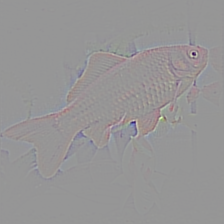

In [4]:
deconv_timer = torch.Timer()
vis_c13= deconvNet_VGG:forward(net:get(29).output)

print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')
itorch.image(vis_c13)